### Getting Data

In [1]:
import wget
from zipfile import ZipFile
from pathlib import Path

def download_and_extract_zip_into_folder(
    zip_url : str,
    data_dir : str = "data/"
)->None:
    """Download and Extract Zip Url into target folder

    Args:
        zip_url (str): url of zip file
        data_dir (str, optional): folder to extract data. Defaults to "data/".
    """
    data_path = Path(data_dir)
    zip_name = Path(zip_url).stem
    
    # Setup new folder path into data folder
    new_folder_path = data_path / zip_name

    # If the new folder doesn't exist, download it and prepare it... 
    if new_folder_path.is_dir():
        print(f"[INFO] : {new_folder_path} directory exists, do nothing.")

    else:
        print(f"[INFO] : Creating {new_folder_path} directory")
        new_folder_path.mkdir(parents=True, exist_ok=True)

        # Download zip file
        zip_file = wget.download(zip_url)
        print(f"[INFO] : Download {zip_file}")
        zip_file = Path(zip_file)
        
        # Unzip zipfile in new folder
        ziper = ZipFile(zip_file)
        ziper.extractall(new_folder_path)
        print(f"[INFO] : Extract {zip_file} here : {new_folder_path}")

        # Remove zip File
        print(f"[INFO] : Remove {zip_file}...")
        zip_file.unlink()
    
    return (new_folder_path)

In [3]:
download_and_extract_zip_into_folder(
    zip_url="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    data_dir="data/",
)

[INFO] : Creating data/pizza_steak_sushi_20_percent directory
[INFO] : Download pizza_steak_sushi_20_percent.zip
[INFO] : Extract pizza_steak_sushi_20_percent.zip here : data/pizza_steak_sushi_20_percent
[INFO] : Remove pizza_steak_sushi_20_percent.zip...


PosixPath('data/pizza_steak_sushi_20_percent')

In [15]:
from pathlib import Path
 
# Setup train and testing paths
PARENT_FOLDER = Path("data/pizza_steak_sushi_20_percent")

TRAIN_DIR = PARENT_FOLDER / "train"
TEST_DIR = PARENT_FOLDER / "test"

PARENT_FOLDER, TRAIN_DIR, TEST_DIR

(PosixPath('data/pizza_steak_sushi_20_percent'),
 PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Import `EfficientNetB0` Pretrained Weight and Image transformer

In [16]:
from torchvision.models import EfficientNet_B0_Weights
from torchvision.models import efficientnet_b0

# Get the Weight of Model `DEFAULT` == last best version
weights = EfficientNet_B0_Weights.DEFAULT

preprocessing = weights.transforms()

# Give Weight to model architecture
efficientnetb0 = efficientnet_b0(weights=weights)

In [17]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root=TRAIN_DIR,
                            transform=preprocessing)

test_dataset = ImageFolder(root=TEST_DIR,
                           transform=preprocessing)

len(train_dataset), len(test_dataset)

(450, 150)

In [18]:
from torch.utils.data import DataLoader
import os 

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True 
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False # don't necessarily have to shuffle the testing data
)

len(train_dataloader), len(test_dataloader)

(15, 5)

### Convert `EfficientNetB0` to Feature Extractor
- Create a custom `Module` Pytorch with :
- Frozen all parameters
- Change Head of Model `classifier`

In [19]:
from utils.transfert_learning import frozen_module_parameters
from torch.nn import Sequential, Dropout, Linear

efficientnetb0_feature_extractor = frozen_module_parameters(module=efficientnetb0) 
efficientnetb0_feature_extractor.classifier = Sequential(
    Dropout(p=0.2),
    Linear(in_features=1280, out_features=3)
)

In [20]:
from torchinfo import summary

summary(model=efficientnetb0_feature_extractor, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [21]:
import torch 

### Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


  0%|          | 0/5 [00:00<?, ?it/s]

Epochs            | Train Loss        | Train Accuracy    | Val Loss          | Val Accuracy      |
20.0% [1/5]       | 0.6941            | 0.7375            | 0.2684            | 0.9131            |
-----------------------------------------------------------------------------------------------
40.0% [2/5]       | 0.3144            | 0.8812            | 0.1987            | 0.9097            |
-----------------------------------------------------------------------------------------------
60.0% [3/5]       | 0.2714            | 0.8771            | 0.2577            | 0.8920            |
-----------------------------------------------------------------------------------------------
80.0% [4/5]       | 0.2152            | 0.9375            | 0.2807            | 0.8881            |
-----------------------------------------------------------------------------------------------
100.0% [5/5]      | 0.1870            | 0.9313            | 0.3260            | 0.8648            |
----------------

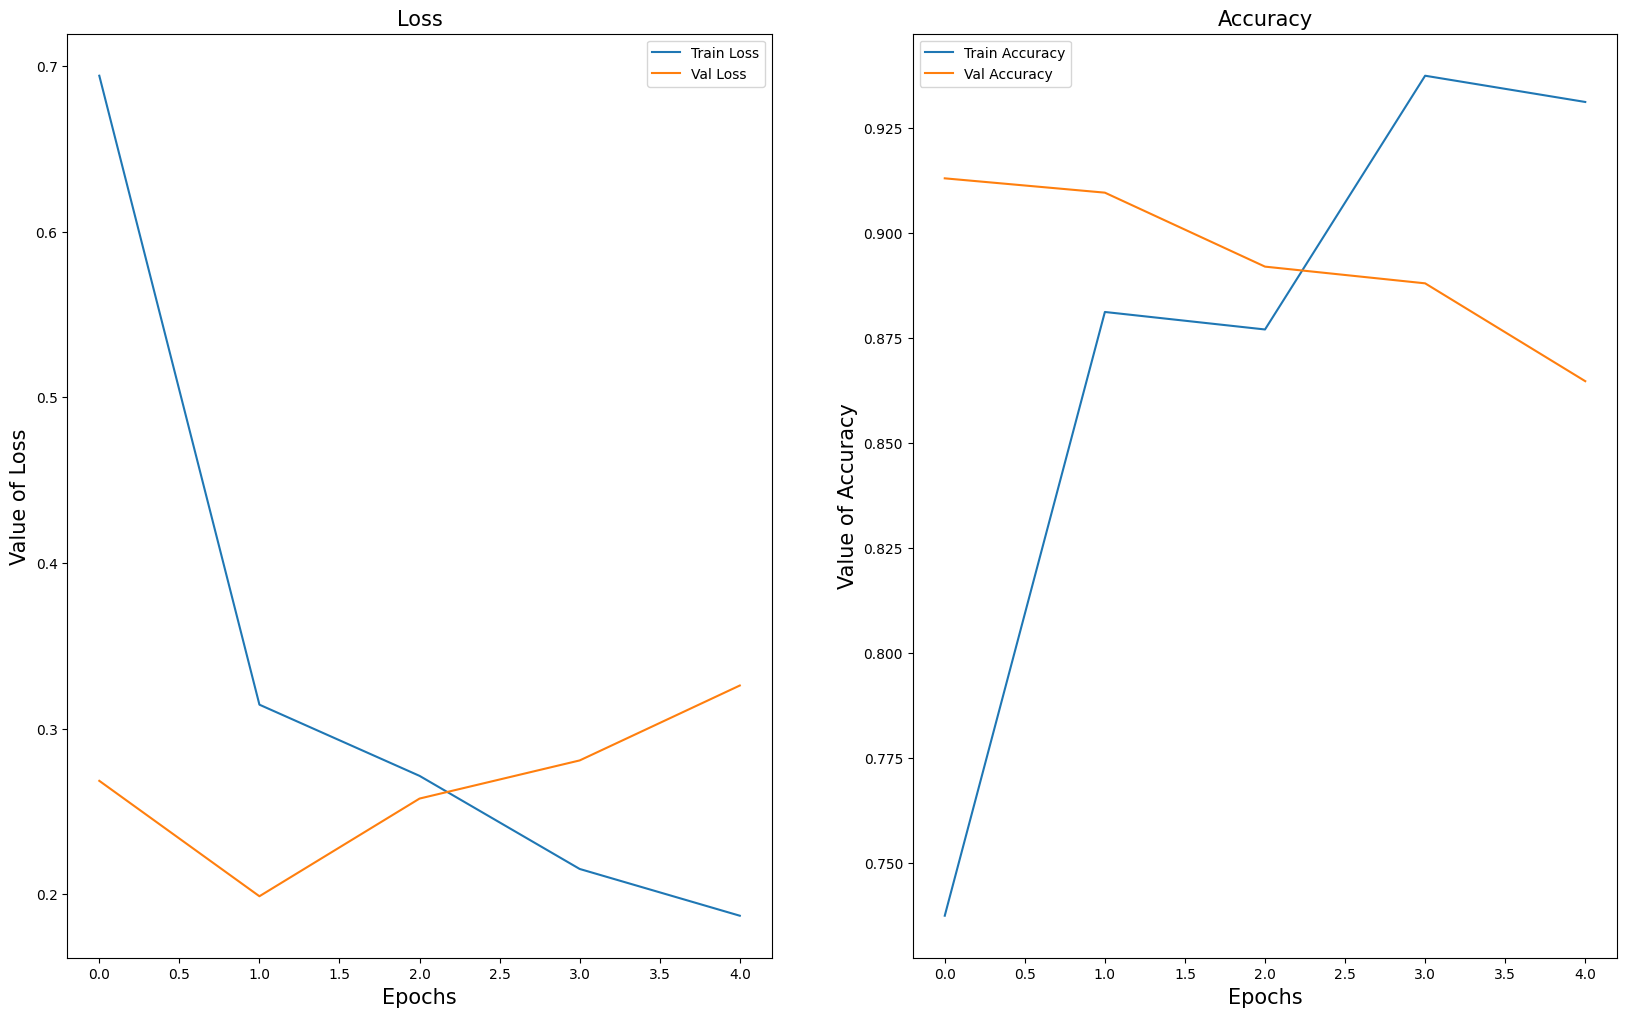

In [22]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torchmetrics.classification import F1Score
from utils.training.core import train

efficientnetb0_feature_extractor.to(device)


metric_function = F1Score(task="multiclass", num_classes=3)
optimizer = Adam(efficientnetb0_feature_extractor.parameters(), lr=0.01)
loss_function = CrossEntropyLoss()


history = train(
    model=efficientnetb0_feature_extractor,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    metric_function=metric_function,
    device=device,
    epochs=5
)

In [23]:
!rm -rf experiments/experiment_test

In [24]:
from saver.experiment import ExperimentSaver

saver = ExperimentSaver(
    experiment_name="experiment_2",
    model_name="efficient_net_b0",
    location="experiments/",
)


[INFO] : Initialize experiment_2
[INFO] : Create [experiments/experiment_2] Directory
[INFO] : [experiments/log.txt] already initialized, append information inside


In [25]:
num_epochs = len(history["Epochs"])
last_train_accuracy = history["Train Accuracy"][-1]
last_test_accuracy = history["Val Accuracy"][-1]
underfitting_diagnostic = history["Bias and UnderFitting"]
overfitting_diagnostic = history["Variance and OverFitting"]
training_time = history["Training Time"]
experiment_figures = [history["Curve Figure"]]

# ****************************************************

saver.create_experiment(
    model=efficientnetb0_feature_extractor,
    input_shape=(1, 3, 224, 224),
    dataset_size="20%",
    batch_size=BATCH_SIZE,
    epochs=num_epochs,
    last_train_accuracy=last_train_accuracy,
    last_test_accuracy=last_test_accuracy,
    underfitting_diag=underfitting_diagnostic,
    overfitting_diag=overfitting_diagnostic,
    figures=experiment_figures,
    optimizer=optimizer,
    device=device,
    training_time=training_time,
    extras_info=""
)

[INFO] : Saving EfficientNet with 4,011,391 Parameters
[INFO] : Saving EfficientNet as efficient_net_b0 in : [experiments/experiment_2/efficient_net_b0.pth]
[INFO] : Saving Figure : [experiments/experiment_2/fig_0]
[INFO] : Saving Graph of Network Architecture in : [experiments/experiment_2/experiment_summary.txt]
[INFO] : Saving Experiment Information in : [experiments/experiment_2/experiment_summary.txt]
[INFO] : Saving experiment_2 Successfully !
[INFO] : Append experiment_2 information in [experiments/log.txt]
